## Trabalho 3: Inversão de dados de perfil sísmico de poço, com regularização Tikhonov de ordem 0 e 1
### Disciplina: Problemas Inversos II
### Professor: Raphael Vieira Menezes de Souza
### Aluno: Matheus Klatt


1) Importando os módulos que contém as funções necessárias a realização do trabalho

In [1]:
#1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics, linear_model, preprocessing
import seaborn as sns
import matplotlib.patches as patches
from scipy import interpolate
import time
%matplotlib inline

2) Leitura do arquivo "dadosVSP.csv", o qual contém as profundidades dos receptores ($m$) e os tempos de chegada/trânsito, da onda sísmica, ($s$) neles registrados.

In [2]:
#2)
# Usando a função pandas.read_csv para ler o arquivo com os dados, "dadosVSP.csv".
trab3_df=pd.read_csv("dadosVSP.csv",header=None,names=["z","t"])

3) Visualizando os dados lidos do arquivo "dadosVSP.csv" no formato $\textit{dataframe}$ do pandas.

In [3]:
#3)
trab3_df

,z,t
0,10.0,0.00700
1,20.0,0.01200
2,30.0,0.01500
3,40.0,0.02200
4,50.0,0.02300
...,...,...
95,960.0,0.35295
96,970.0,0.35181
97,980.0,0.35667
98,990.0,0.35752


4) Montagem do problema na forma matricial: $\mathbf{d} = \mathbf{G}\mathbf{m}$. Nesta forma o vetor $\mathbf{d}$ guarda a variável predita/dependente, a matriz $\mathbf{G}$ contém as variáveis independentes/preditores e o vetor $\mathbf{m}$ corresponde aos coeficientes/parâmetros que se deseja obter pela solução do problema inverso. 

Neste caso é importante atentar a maneira como o problema foi discretizado, para montagem correta da matriz $\mathbf{G}$. A subsuperfície foi discretizada em 50 partes/intervalos de 20 m (totalizando os 1000 m de profundidade) que correspondem a cada uma das colunas da matriz $\mathbf{G}$. As 100 linhas de $\mathbf{G}$ estão associadas cada uma aos 100 tempos de trânsito registrados em $\mathbf{d}$, os quais foram observados em intervalos regulares de 10 m em profundidade. Uma representação esquemática da perfilagem é mostrada a seguir:

<img src="profile_scheme.png" width="400" height="400"/>

Esta geometria de aquisição e discretização do problema resulta em dois registros para cada parte da subsuperfície. Portanto, cada linha da matriz $\mathbf{G}$ guarda a distância em profundidade vertical percorrida pela onda em cada uma das 50 partes nas quais o meio de propagação da onda foi discretizado. A soma dos valores de cada linha de $\mathbf{G}$ equivale a profundidade na qual o tempo de chegada da onda foi registrado nos receptores. Deste modo os valores dos elementos da matriz podem ser 0.0 m, quando a onda ainda não chegou na parte da subsuperfície considerada, $\Delta s_{1} = 10 m$, quando a onda á percorreu metade da unidade discreta de subsuperfície, e $\Delta s_{2} = 20$ m quando a onda já percorrreu completamente os 20 m de extensão do intervalo discreto considerado.

Desta forma o sistema pode ser escrito da seguinte forma

$\begin{equation}
\mathbf{d}_{100 x 1} = \mathbf{G}_{100 x 50} \cdot \mathbf{m}_{50 x 1} = 
\begin{bmatrix}
d_0\\
\vdots\\
d_{99}
\end{bmatrix}_{100 x 1}
=
\begin{bmatrix}
\Delta s_{1} & 0.0 & 0.0 & \cdots & 0.0 & 0.0\\
\Delta s_{2} & 0.0 & 0.0 & \cdots & 0.0 & 0.0\\
\Delta s_{2} & \Delta s_{1} & 0.0 & \cdots & 0.0 & 0.0\\
\Delta s_{2} & \Delta s_{2} & 0.0 & \ddots & 0.0 & 0.0\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
\Delta s_{2} & \Delta s_{2} & \Delta s_{2} & \cdots & \Delta s_{2} & \Delta s_{1}\\
\Delta s_{2} & \Delta s_{2} & \Delta s_{2} & \cdots & \Delta s_{2} & \Delta s_{2}\\
\end{bmatrix}_{100 x 50}
\cdot
\begin{bmatrix}
s_{0}\\
\vdots\\
s_{49}\\
\end{bmatrix}_{50 x 1}
\end{equation}$


In [4]:
#4) Montando os elementos do sistema, d e G

# Inicializando G para uma matriz de zeros, 100 x 50
G=np.zeros((100,50),dtype=np.float32)

# Laço que preenche G adequadamente com os valores 10.0
j=1
for i in range(0,len(G[:,0])):
    G[i,:j]=1.*(trab3_df[["z"]].to_numpy()[1]-trab3_df[["z"]].to_numpy()[0])
    if((i)%2 and i!=0):
        j=j+1   

# Laço que preenche G adequadamente com os valores 20.0        
i=1
for j in range(0,len(G[0,:])):
    G[i:,j]=2.*G[i:,j]
    i+=2


# Construção do vetor d a partir da coluna "t" do dataframe, a qual contém os tempos de chegada registrados 
d=trab3_df["t"].to_numpy().reshape((-1,1))

# Exibição das dimensões de G e d para verificação de que foram corretamente construídos
print("Shape G: ",G.shape,"Shape d: ",d.shape)

Shape G:  (100, 50) Shape d:  (100, 1)


5) Visualizando e verificando a matriz G, uma visualização ampliada da região delimitada em vermelho é mostrada em $\textbf{#6}$.

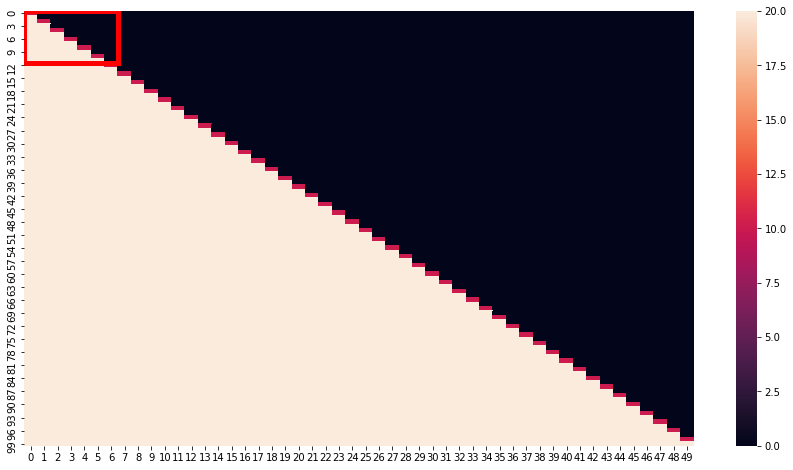

In [5]:
#5) Visualização e verificação da construção correta da matriz G
fig, (ax1) = plt.subplots(1,1,figsize=(15,8))
rect = patches.Rectangle((0,0),7,12,linewidth=5,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
ax1=sns.heatmap(G)

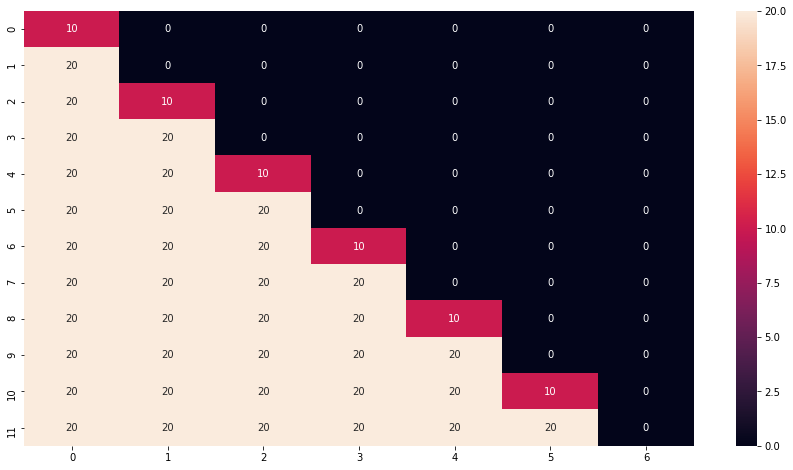

In [6]:
#6) Visão ampliada da área da matriz G dentro do retângulo vermelho de 5)
fig, (ax1) = plt.subplots(1,1,figsize=(15,8))
ax1=sns.heatmap(G[:12,:7],annot=True)

7) Um preprocessamento dos dados do vetor $\mathbf{d}$ mostra possíveis erros nos registros. Conforme a profundidade dos receptores aumenta é esperado que os tempos de trânsito dos registros aumentem progressivamente, portanto cada um dos tempos de chegada deve ser maior que os tempos que o antecedem. No entanto, observa-se que algumas leituras tem valor registrado maior que a entrada seguinte, isto ocorre especificamente com as amostras: $d_{14},d_{33},d_{35},d_{47},d_{61},d_{65},d_{69},d_{78},d_{81},d_{88}$ e $d_{96}$. Neste caso algumas abordagens são possíveis, dentre elas: ignorar os erros e realizar a inversão, ou então remover as entradas com valor incoerente e substitui-las por valores interpolados utilizando as entradas corretas. Aqui adotamos as duas abordagens e comparamos os modelos obtidos. Sendo assim, primeiro criamos o novo vetor de dados,  $\mathbf{d}_{int}$, o qual armazenará os registros com valores errôneos substituidos por valores interpolados.

In [7]:
#7) Construção do vetor alternativo de dados corrigidos por interpolação, d_int

# lista que guarda indices de elementos do vetor de dados d com valores erroneos/incoerentes, i.e.,
# valores menores ou iguais que os anteriores 
pidx=[]

# lista que guarda indices de elementos do vetor de dados d com valores corretos/coerentes
idx=[]

# laço para determinacao dos indices dos elementos corretos e incorretos
for i in range(0,len(d[:,0])-1):
    if (d[i,0]>=d[i+1,0]):            
        pidx.append(i+1)
    else:
        idx.append(i+1)

# remocao dos valores incorretos e interpolacao de novos valores para substituir aqueles que foram removidos
d_i=d[idx].reshape((-1))
z_i=trab3_df[["z"]].to_numpy()[idx].reshape((-1))
f = interpolate.interp1d(z_i, d_i,kind="cubic",assume_sorted=True)
x_new=trab3_df[["z"]].to_numpy()[pidx].reshape((-1))
y_new=f(x_new)
rep_=d[pidx]
y_idx=0
d_int=np.copy(d)
for i in pidx:
    d_int[i]=y_new[y_idx]
    y_idx+=1



In [8]:
#8) comparacao entre valores dos tempos de chegada no vetor d original e no novo vetor d com valores incorretos 
# substituidos por valores interpolados
print("Dados originais:\n",d.ravel(),"\n")
print("Dados interpolados:\n",d_int.ravel(),"\n")

Dados originais:
 [0.007   0.012   0.015   0.022   0.023   0.028   0.035   0.04    0.043
 0.052   0.054   0.058   0.062   0.068   0.068   0.074   0.08    0.082
 0.084   0.088   0.096   0.1     0.102   0.106   0.112   0.114   0.12
 0.124   0.126   0.13    0.132   0.138   0.144   0.144   0.152   0.152
 0.156   0.162   0.166   0.17    0.176   0.18    0.182   0.188   0.19
 0.194   0.2     0.2     0.206   0.208   0.21133 0.21867 0.222   0.22533
 0.22867 0.232   0.23533 0.23667 0.242   0.24533 0.24867 0.248   0.25333
 0.25467 0.262   0.26133 0.26667 0.268   0.27533 0.27467 0.27752 0.28038
 0.28524 0.2861  0.29095 0.29181 0.29467 0.30152 0.30038 0.30524 0.3101
 0.30895 0.31381 0.31667 0.31752 0.32038 0.32324 0.3301  0.32895 0.33581
 0.33867 0.33952 0.34038 0.34524 0.3481  0.35295 0.35181 0.35667 0.35752
 0.36038] 

Dados interpolados:
 [0.007      0.012      0.015      0.022      0.023      0.028
 0.035      0.04       0.043      0.052      0.054      0.058
 0.062      0.068      0.07091477 0

9) Com os dados preprocessados a primeira solução que buscamos aqui é a solução pelo uso das equações normais para minimização da norma L2. Neste problema a matriz $\mathbf{G}_{100 x 50}$ tem posto completo, i.e., $rank(\mathbf{G}) = 50$ e portanto admite inversa, não sendo necessário utilizar a pseudoinversa da SVD. Esta primeira solução servirá de referência para comparação com as soluções que fazem uso da regularização de Tikhonov de ordem 0 e ordem 1.

In [9]:
#9) Solucao pelas equacoes normais
# Calculando (G.T G)-1
inv_G=np.linalg.inv(np.matmul(G.T,G))
# Calculando G.T d
GTd=np.matmul(G.T,d)
# multiplicando (G.T G)-1 e G.T d para obter m
m=np.matmul(inv_G,GTd)

In [10]:
#10) Visualização dos parâmetros obtidos pela solução das equações normais
m.ravel()

array([0.00059426, 0.00044044, 0.00036334, 0.00057908, 0.00056217,
       0.00034796, 0.00044974, 0.00035435, 0.00042517, 0.00029561,
       0.00060211, 0.00029268, 0.00044278, 0.00045161, 0.0002485 ,
       0.00045829, 0.00040263, 0.00032681, 0.0004374 , 0.00044968,
       0.00046537, 0.00035894, 0.00038179, 0.00035111, 0.0003123 ,
       0.00050885, 0.00036931, 0.00034197, 0.00024657, 0.00044626,
       0.0001425 , 0.00036638, 0.00032682, 0.00033924, 0.00030525,
       0.00024878, 0.00033555, 0.00022535, 0.00039779, 0.0002733 ,
       0.00024979, 0.0003133 , 0.00015669, 0.00043183, 0.00033955,
       0.00021606, 0.00024913, 0.00037607, 0.00017937, 0.0002337 ])

11) Primeira availiação comparativa entre modelo real e soluções obtidas pelas equações normais com regularização (Tikhonov de ordem 0 e ordem 1) e sem regularização. Conforme as notas de aula o modelo real, $\mathbf{m}_{real}$ tem o seguinte perfil de velocidade

$\begin{equation}
\mathbf{m}_{real} = 
\begin{cases} 
2000 m/s, & z\lt 100 m \\
2500 m/s, & 100 m\leq z\lt 500 m \\
3000 m/s, & 100 m\leq z\lt 700 m \\
3500 m/s, & 700 m\leq z\lt 1000 m 
\end{cases}
\end{equation}$

Esta primeira avaliação é qualitativa e compara as curvas do perfil de velocidade real, e dos perfis resultantes das diferentes soluções.

In [11]:
#11) Construção do vetor que guarda os valores reais do perfil de velocidade do problema,
# de acordo com as notas de aula o perfil é: 
# 2000m/s até 100m, 2500m/s de 100m a 500m, 3000m/s de 500 a 700m e 3500m/s de 700 a 1000m.

true_v=np.vstack((np.ones((5,1))*2000.,np.ones((20,1))*2500.,np.ones((10,1))*3000.,np.ones((15,1))*3500.))

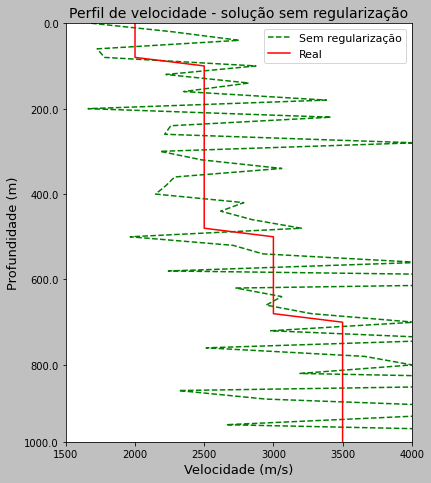

In [12]:
#12) Gráfico dos perfis de velocidade real (vermelho) e 
# solução não regularizada (m,d) com conjunto de dados original (verde tracejado)
fig_L, (ax1)=plt.subplots(1,1,figsize=(6.2,7.7))
fig_L.set_facecolor("silver")
ax1.plot(1/m.ravel(),np.arange(0,len(m.ravel())),linestyle="--", label="Sem regularização",c="green")
ax1.plot(true_v,np.arange(0,len(m.ravel())),c="red", label="Real")

ax1.set_xlim(1500.,4000.)
ax1.set_ylim(0.,49.)
ax1.invert_yaxis()
ax1.set_title('Perfil de velocidade - solução sem regularização',fontsize=14)
ax1.set_xlabel('Velocidade (m/s)',fontsize=13)
ax1.set_ylabel('Profundidade (m)',fontsize=13)
ax1.set_yticks([0,10,20,30,40,49])
ax1.set_yticklabels(["0.0","200.0","400.0","600.0","800.0","1000.0"])
ax1.legend(fontsize=11)

13) Percebe-se pelo gráfico que a solução obtida das equações normais, apesar de seguir a mesma tendência do modelo real, é extremamente ruidosa. Este é um tipo de comportamente que pode ser atenuado com o uso de técnicas de regularização.

14) A regularização de Tikhonov é um método largamente utilizado em problemas inversos discretos de posto deficiente. Essencialmente esse método depende do parâmetro de regularização $\alpha$, o qual controla a intensidade da regularização, e da matriz $\mathbf{L}$, a qual é incorporada em uma versão aumentada de $\mathbf{G}_{m x n}$ e determina o perfil da solução $\mathbf{m}^{\alpha}_{n x 1}$ obtida.

A incorporação destes elementos permite que o problema seja escrito no formato padrão de um problema linear de mínimos quadrados, mas regularizado, se tomamos

$\begin{equation}
\mathbf{G}^{\#}
= 
{\begin{bmatrix}
\mathbf{G}\\
\alpha\mathbf{L}\\
\end{bmatrix}}
\end{equation}$

, e

$\begin{equation}
\mathbf{d}^{\#}
= 
{\begin{bmatrix}
\mathbf{d}\\
\mathbf{0}\\
\end{bmatrix}}
\end{equation}$

, então

$\begin{equation}
\mathbf{m}^{\alpha} = (\mathbf{G}^{\#T}\mathbf{G}^{\#})^{-1}\mathbf{G}^{\#T}\mathbf{d}^{\#T}
\end{equation}$

,que objetiva

$\begin{equation}
min{\bigg\lvert\bigg\lvert
{\begin{bmatrix}
\mathbf{G}\\
\alpha\mathbf{L}\\
\end{bmatrix}}
\mathbf{m}
-
{\begin{bmatrix}
\mathbf{d}\\
\mathbf{0}\\
\end{bmatrix}}\bigg\rvert\bigg\rvert}_{2}^{2}
\end{equation}$

A escolha da matriz $\mathbf{L}$ depende do aspecto desejado para a solução $\mathbf{m^{\alpha}}$. Aqui avaliamos o efeito das regularizações de Tikhonov de ordem 0 e ordem 1. 

Para regularização Tikhonov de ordem 0 a matriz $\mathbf{L}$ = $\mathbf{L}_{0}$ é simplesmente

$\begin{equation}
\mathbf{L}_{0} = \mathbf{I}
\end{equation}$

O efeito da Tikhonov de ordem 0 é a penalização dos valores obtidos para os parâmetros do modelo $\mathbf{m^{\alpha}}$ baseado nos próprios valores dos parâmetros.

A regularição de Tikhonov de ordem 1 atua sobre a derivada primeira de $\mathbf{m^{\alpha}}$ levando consequentemente a soluções mais suaves. Para modelos unidimensionais discretizados em uma malha regular $\mathbf{L}$ = $\mathbf{L}_{1}$ assume a seguinte forma

$\begin{equation}
\mathbf{L}_{1} 
= 
\begin{bmatrix}
-1 & 1 &  &  &  & \\
 & -1 & 1 &  &  & \\
 &  & \ddots & \ddots &  & \\
 &  &  & -1 & 1 & \\
 &  &  &  & -1 & 1
\end{bmatrix}_{n - 1 x n}
\end{equation}$

Nota-se que desde que o parâmetro $\alpha$ seja diferente de zero, as últimas $n$ linhas de $\mathbf{G}^{\#}$ são linearmente independentes, tornando-a uma matriz de posto completo permitindo a resolução pelo uso das equações normais.

Um dos desafios em se encontrar uma regularização adequada é justamente definir o valor do parâmetro $\alpha$. Se os valores singulares de $\mathbf{G}$ são conhecidos uma heurística comumente utilizada é a busca por valores de $\alpha$ em uma faixa de magnitudes que compreenda  desde o menor até o maior valor singular. Caso contrário, quando não há nenhum conhecimento a priori sobre características do problema o ideal é realizar a busca pelo valor ideal de $\alpha$ num intervalo grande de magnitudes.

Ademais, a escolha do melhor modelo regularizado normalmente envolve um compromisso entre um modelo que minimize adequadamente tanto a seminorma dos parâmetros ${\lvert\lvert\mathbf{L}\mathbf{m}^{\alpha}\rvert\rvert}_{2}$, quanto a seminorma dos resíduos ${\lvert\lvert\mathbf{G}^{\#}\mathbf{m}^{\alpha} - \mathbf{d}\rvert\rvert}_{2}$. Para fazer essa avaliação costuma-se fazer o gráfico da evolução das duas seminormas para diferentes valores de $\alpha$. A seminorma da solução é uma função decrescente de $\alpha$, enquanto a seminorma dos resíduos é uma função crescente de $\alpha$. Em problemas lineares quando o gráfico é construído em escala logarítmica em ambos os eixos a curva assume um formato de "L" sendo usualmente escolhido o modelo correspondente ao ponto de inflexão da curva a partir do qual observa-se rápido crescimento da seminorma dos resíduos, e.g., o ponto circulado na curva de exemplificação abaixo. 

<img src="norma_reg_tikh.png" width="500" height="500"/>

In [13]:
#14) Definição da função reg_inv, a qual calcula as soluções regularizadas por Tikhonov de ordem 0 e ordem 1.
# A funcão reg_inv recebe como argumentos a matriz G, construida em 4), o vetor de dados d 
# (lembrando que aqui são calculadas soluções para d e d_int, ver 7)), um vetor 'alpha'
# contendo os valores deste parâmetro que se deseja testar, e o parâmetro 'order', o qual define qual tipo 
# de regularizaçao será implementada, Tikhonov de ordem 0 (order=0), ou Tikhonov de ordem 1 (order = 1).

def reg_inv(G,d,alpha,order=0):
    
    # Lista que guarda soluções obtidas para cada valor de alpha testado
    models_list=[]
    # Lista que guarda seminorma da solução para cada valor de alpha testado
    model_l2_norm_list=[]
    # Lista que guarda seminorma dos resíduos para cada valor de alpha testado
    res_l2_norm_list=[]
    
    G_safe=np.copy(G)
    d_safe=np.copy(d)
    #Laço que resolve o problema pelas equações normais para cada um dos valores do vetor alpha
    for a in alpha:
        G=np.copy(G_safe)
        d=np.copy(d_safe)
        # Se o parâmetro order = 0, montagem da matriz aumentada G# e resolução pelas equações normais para
        # regularização de Tikhonov de ordem 0
        if (order==0):
            
            # Tikhonov de ordem 0, L (tikh_1) é simplesmente a matriz identidade I de dimensões n x n
            tikh_1=np.eye(len(G[0,:]))
            tikh_1=tikh_1*a
            
            # criação de G#, e d#, conforme 9)
            d=np.vstack((d,np.zeros((len(tikh_1[:,0]),1))))   
            G=np.vstack((G,tikh_1))
            
            # Resolução pelas equacoes normais
            # Calculando (G.T G)-1
            inv_G=np.linalg.inv(np.matmul(G.T,G))
            # Calculando G.T d
            GTd=np.matmul(G.T,d)
            # Multiplicando (G.T G)-1 e G.T d para obter m
            m=np.matmul(inv_G,GTd)
            
            # guardando modelo atual na lista de modelos, a lista nao as vagarosidades m, mas sim a velocidade
            # 1/m
            models_list.append((1/m))
            # guardando seminorma da solução atual na lista especifica
            model_l2_norm_list.append(np.linalg.norm(np.matmul(tikh_1/a,(m)),2))
            # guardando seminorma dos residuos atual na lista especifica
            res_l2_norm_list.append(np.linalg.norm(np.matmul(G,(m))-d,2))
        
        # Se o parâmetro order = 1, montagem da matriz aumentada G# e resolução pelas equações normais para
        # regularização de Tikhonov de ordem 1
        else:
            
            # montagem de L1, conforme mostrado em 9)
            tikh_1=np.eye(len(G[:,0]))*-1
            for j in range(0,len(G[:,0])):
                for i in range(0,len(G[:,0])):
                    if j==i+1:
                        tikh_1[i,j]=1
            tikh_1=tikh_1*a
            tikh_1=tikh_1[:len(G[0,:]),:len(G[0,:])]
            
            # criação de G#, e d#, conforme 9)
            d=np.vstack((d,np.zeros((len(tikh_1[:,0]),1))))   
            G=np.vstack((G,tikh_1))
            G=G[:-1,:]
            d=d[:-1,0]
            tikh_1=tikh_1[:-1,:]
            
            # Resolução pelas equacoes normais
            # Calculando (G.T G)-1                
            inv_G=np.linalg.inv(np.matmul(G.T,G))
            # Calculando G.T d
            GTd=np.matmul(G.T,d)
            # multiplicando (G.T G)-1 e G.T d para obter m
            m=np.matmul(inv_G,GTd)
            
            # guardando modelo atual na lista de modelos, a lista nao as vagarosidades m, mas sim a velocidade
            # 1/m
            models_list.append((1/m))            
            # guardando seminorma da solução atual na lista especifica            
            model_l2_norm_list.append(np.linalg.norm(np.matmul(tikh_1/a,(m)),2))
            # guardando seminorma dos residuos atual na lista especifica            
            res_l2_norm_list.append(np.linalg.norm(np.matmul(G,(m))-d,2))
        
    # a funcao reg_inv retorna as seguintes variaveis:
    # lista com todas as solucoes obtidas, lista das seminormas das solucoes, lista das seminormas dos residuos,
    # G# e L
    return(models_list,model_l2_norm_list,res_l2_norm_list,G,tikh_1)

# vetor que armazena os valores de alpha a serem testados, aqui foram experimentados valores de 1e-6 a 1e4
alpha=np.logspace(-6,4,75)

# calculo das solucoes com regularização de Tikhonov de ordem 0, utilizando o vetor original de dados d
ml_0,ml2nl_0,rl2nl_0,G_reg_0,L0=reg_inv(G,d,alpha,order=0)
# calculo das solucoes com regularização de Tikhonov de ordem 1, utilizando o vetor original de dados d
ml_1,ml2nl_1,rl2nl_1,G_reg_1,L1=reg_inv(G,d,alpha,order=1)
# calculo das solucoes com regularização de Tikhonov de ordem 0, utilizando o vetor de dados corrigidos por
# interpolação d_int, ver 6)
ml_0_int,ml2nl_0_int,rl2nl_0_int,G_reg_0_int,L0_int=reg_inv(G,d_int,alpha,order=0)
# calculo das solucoes com regularização de Tikhonov de ordem 1, utilizando o vetor de dados corrigidos por
# interpolação d_int, ver 6)
ml_1_int,ml2nl_1_int,rl2nl_1_int,G_reg_1_int,L1_int=reg_inv(G,d_int,alpha,order=1)

15) Os modelos obtidos utilizando as duas regularizações de Tikhonov, de ordem 0 e ordem 1, para os dois conjuntos de dados $\mathbf{d}$(original) e $\mathbf{d}_{int}$ (corrigido por interpolação) são analisados pela inspeção das curvas "L".

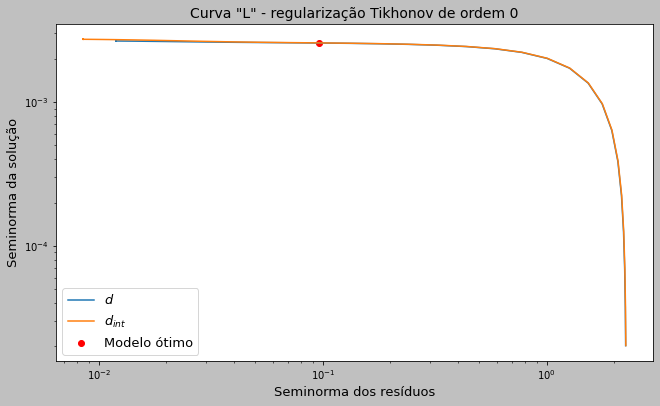

In [14]:
#15) Gráfico da curva-L para soluções obtidas utilizando a regularização de Tikhonov de ordem 0, e valores do
# parâmetro alpha [1e-6,1e4]. O modelo ótimo (em vermelho) foi escolhido com base na curva L 
# das soluções obtidas para o conjunto de dados corrigidos por interpolação d_int.
fig_L, (ax1)=plt.subplots(1,1,figsize=(10.7,6.2))
fig_L.set_facecolor("silver")
ax1.loglog(rl2nl_0,ml2nl_0, label="$d$")
ax1.loglog(rl2nl_0_int,ml2nl_0_int, label="$d_{int}$")
ax1.scatter(rl2nl_0_int[56],ml2nl_0_int[56],c="red",label="Modelo ótimo") 
#ax1.set_xlim(1e-2,5e-1)
#ax1.set_ylim(2.55e-3,2.75e-3)

ax1.set_title('Curva "L" - regularização Tikhonov de ordem 0',fontsize=14)
ax1.set_xlabel('Seminorma dos resíduos',fontsize=13)
ax1.set_ylabel('Seminorma da solução',fontsize=13)

ax1.legend(fontsize=13)

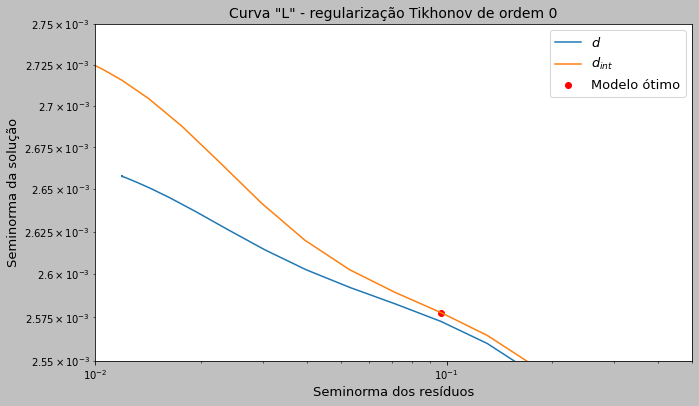

In [15]:
#16) Visão ampliada da região do gráfico da curva-L para soluções
# obtidas utilizando a regularização de Tikhonov de ordem 0, e valores do
# parâmetro alpha [1e-6,1e4]. O modelo ótimo (em vermelho) foi escolhido com base na curva L 
# das soluções obtidas para o conjunto de dados corrigidos por interpolação d_int.
fig_L, (ax1)=plt.subplots(1,1,figsize=(10.7,6.2))
fig_L.set_facecolor("silver")
ax1.loglog(rl2nl_0,ml2nl_0, label="$d$")
ax1.loglog(rl2nl_0_int,ml2nl_0_int, label="$d_{int}$")
ax1.scatter(rl2nl_0_int[56],ml2nl_0_int[56],c="red",label="Modelo ótimo") 
ax1.set_xlim(1e-2,5e-1)
ax1.set_ylim(2.55e-3,2.75e-3)

ax1.set_title('Curva "L" - regularização Tikhonov de ordem 0',fontsize=14)
ax1.set_xlabel('Seminorma dos resíduos',fontsize=13)
ax1.set_ylabel('Seminorma da solução',fontsize=13)

ax1.legend(fontsize=13)

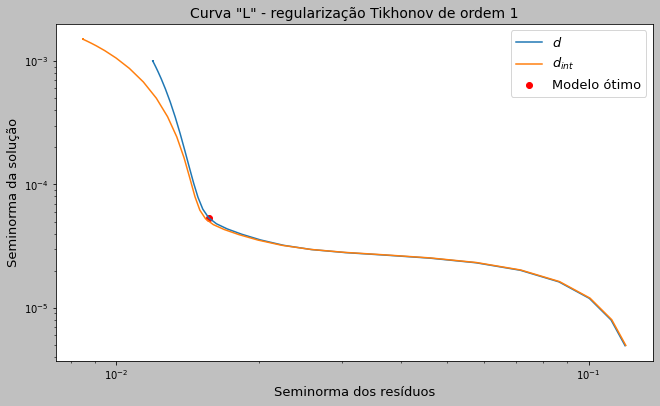

In [16]:
#17) Gráfico da curva-L para soluções obtidas utilizando a regularização de Tikhonov de ordem 0, e valores do
# parâmetro alpha [1e-6,1e4]. O modelo ótimo (em vermelho) foi escolhido com base na curva L 
# das soluções obtidas para o conjunto de dados corrigidos por interpolação d_int.

fig_L, (ax1)=plt.subplots(1,1,figsize=(10.7,6.2))
fig_L.set_facecolor("silver")

ax1.loglog(rl2nl_1,ml2nl_1, label="$d$")
ax1.loglog(rl2nl_1_int,ml2nl_1_int, label="$d_{int}$")
#plt.scatter(rl2nl_1,ml2nl_1)
ax1.scatter(rl2nl_1[59],ml2nl_1[59],c="red",label="Modelo ótimo")
ax1.set_title('Curva "L" - regularização Tikhonov de ordem 1',fontsize=14)
ax1.set_xlabel('Seminorma dos resíduos',fontsize=13)
ax1.set_ylabel('Seminorma da solução',fontsize=13)

ax1.legend(fontsize=13)

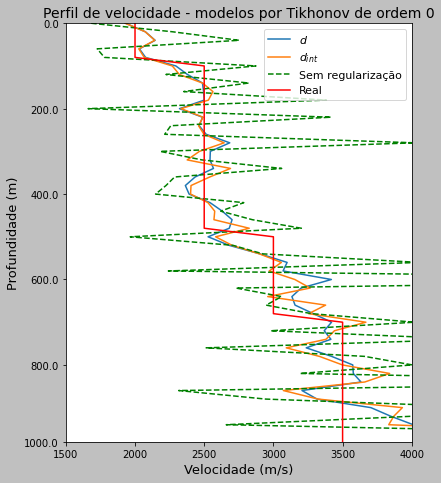

In [17]:
#18) Gráfico dos perfis de velocidade real (vermelho), 
# solução não regularizada (m,d) com conjunto de dados original (verde tracejado), e 
# soluções regularizadas com Tikhonov de ordem 0 para os dados originais (ml_0,d) (azul)
# e dados corrigidos por interpolação (ml_0_int,d_int) (laranja)
fig_L, (ax1)=plt.subplots(1,1,figsize=(6.2,7.7))
fig_L.set_facecolor("silver")
ax1.plot(ml_0[56].ravel(),np.arange(0,len(ml_0[0].ravel())),label="$d$")
ax1.plot(ml_0_int[56].ravel(),np.arange(0,len(ml_0[0].ravel())),label="$d_{int}$")
ax1.plot(1/m.ravel(),np.arange(0,len(ml_0[0].ravel())),linestyle="--", label="Sem regularização",c="green")
ax1.plot(true_v,np.arange(0,len(ml_0[0].ravel())),c="red", label="Real")

ax1.set_xlim(1500.,4000.)
ax1.set_ylim(0.,49.)
ax1.invert_yaxis()
ax1.set_title('Perfil de velocidade - modelos por Tikhonov de ordem 0',fontsize=14)
ax1.set_xlabel('Velocidade (m/s)',fontsize=13)
ax1.set_ylabel('Profundidade (m)',fontsize=13)
ax1.set_yticks([0,10,20,30,40,49])
ax1.set_yticklabels(["0.0","200.0","400.0","600.0","800.0","1000.0"])
ax1.legend(fontsize=11)

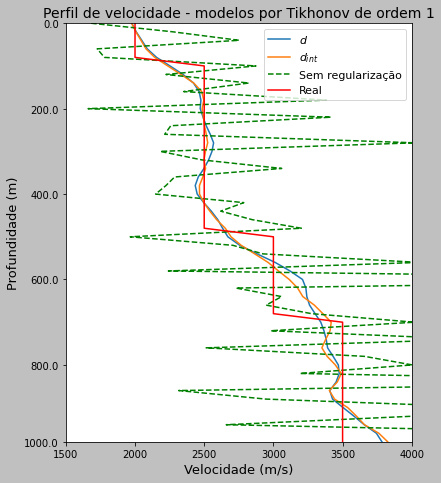

In [18]:
#19) Gráfico dos perfis de velocidade real (vermelho), 
# solução não regularizada (m,d) com conjunto de dados original (verde tracejado), e 
# soluções regularizadas com Tikhonov de ordem 1 para os dados originais (ml_1,d) (azul)
# e dados corrigidos por interpolação (ml_1_int,d_int) (laranja)

fig_L, (ax1)=plt.subplots(1,1,figsize=(6.2,7.7))
fig_L.set_facecolor("silver")
ax1.plot(ml_1[59].ravel(),np.arange(0,len(ml_1[0].ravel())),label="$d$")
ax1.plot(ml_1_int[59].ravel(),np.arange(0,len(ml_1[0].ravel())),label="$d_{int}$")
ax1.plot(1/m.ravel(),np.arange(0,len(ml_0[0].ravel())),linestyle="--",label="Sem regularização",c="green")
ax1.plot(true_v,np.arange(0,len(ml_1[0].ravel())),c="red", label="Real")

ax1.set_xlim(1500.,4000.)
ax1.set_ylim(0.,49.)
ax1.invert_yaxis()
ax1.set_title('Perfil de velocidade - modelos por Tikhonov de ordem 1',fontsize=14)
ax1.set_xlabel('Velocidade (m/s)',fontsize=13)
ax1.set_ylabel('Profundidade (m)',fontsize=13)
ax1.set_yticks([0,10,20,30,40,49])
ax1.set_yticklabels(["0.0","200.0","400.0","600.0","800.0","1000.0"])
ax1.legend(fontsize=11)

20) A segunda avaliação é feita a partir dos resíduos gerados pelas predições de cada um dos modelos obtidos quando comparados com os dados reais, para isso adotamos a métrica do erro médio quadrático ($\textit{mean squared error}$), $\textbf{MSE}$, o qual pode ser calculado como

$\begin{equation}
MSE_{L2} =  \large\frac{\sum_{i=1}^{m}(d_{i} - \hat{d}_{i})^{2}}{m}
\end{equation}$

, onde $d_{i}$ e $\hat{d}_{i}$ são respectivamente elementos dos vetores $\mathbf{d}$ de dados reais e $\hat{\mathbf{d}}$ dados estimados, e $m$ é o número total de amostras/observações. 

In [19]:
#20) Cálculo do MSE para cada uma das soluções obtidas. 
# Nota, o MSE da solução não regularizada é calculado utilizando somente o vetor de dados original 
# (com entradas incorretas), já que este foi o conjunto usado para a construção do modelo não regularizado.
# Para os modelos regularizados o MSE é calculado tanto para o conjunto originald e dados (d), quanto para o
# conjunto de dados corrigido por substituição e interpolaçao (d_int), (ver 7))

# Cálculo do erro médio quadrático da solução não regularizada
MSE_noreg=np.sum(np.add(d.ravel(),-np.matmul(G,m).ravel())**2)/len(d)
# Cálculo do erro médio quadrático da solução regularizada por Tikhonov de ordem 0 com os dados originais (d)
MSE_L0=(rl2nl_0[56]**2)/len(d)
# Cálculo do erro médio quadrático da solução regularizada por Tikhonov de ordem 0 com os dados corrigidos (d_int)
MSE_L0_int=(rl2nl_0_int[56]**2)/len(d_int)
# Cálculo do erro médio quadrático da solução regularizada por Tikhonov de ordem 1 com os dados originais (d)
MSE_L1=(rl2nl_1[59]**2)/len(d)
# Cálculo do erro médio quadrático da solução regularizada por Tikhonov de ordem 1 com os dados corrigidos (d_int)
MSE_L1_int=(rl2nl_1_int[59]**2)/len(d_int)

# Impressão dos valores de MSE calculados para comparação entre as diferentes soluções
print("MSE da solução não regularizada: ", MSE_noreg)
print("MSE da solução regularizada por Tikhonov de ordem 0 utilizando os dados originais 'd': ", MSE_L0)
print("MSE da solução regularizada por Tikhonov de ordem 0 utilizando os dados corrigidos por interpolação 'd': ",
      MSE_L0_int)
print("MSE da solução regularizada por Tikhonov de ordem 1 utilizando os dados originais 'd': ", MSE_L1)
print("MSE da solução regularizada por Tikhonov de ordem 1 utilizando os dados corrigidos por interpolação 'd': ",
      MSE_L1_int)

MSE da solução não regularizada:  1.4267502957459784e-06
MSE da solução regularizada por Tikhonov de ordem 0 utilizando os dados originais 'd':  9.292185623745918e-05
MSE da solução regularizada por Tikhonov de ordem 0 utilizando os dados corrigidos por interpolação 'd':  9.304835773886407e-05
MSE da solução regularizada por Tikhonov de ordem 1 utilizando os dados originais 'd':  2.458206527479535e-06
MSE da solução regularizada por Tikhonov de ordem 1 utilizando os dados corrigidos por interpolação 'd':  2.386004491575042e-06


### Conclusão

A regularização de Tikhonov se mostrou um método efetivo na obtenção de soluções mais comportadas como visto em 18) e 19). Especificamente, o modelo ótimo obtido pela Tikhonov de ordem 0 tem como característica a atenuação de valores extremos, enquanto  solução ótima pela Tikhonov de ordem 1 favorece uma solução de transições mais suaves entre os parâmetros do modelo. 

Em 20) pode-se observar que a regularização explica os dados com o mesmo grau de magnitude que o modelo não regularizado, visto que o erro médio quadrático para os modelos regularizados e não regularizado possuem a mesma ordem de grandeza, o que favorece a opção pelos modelos regularizados.

Apesar da melhoria nas soluções obtidas, ainda se nota uma limitação na resolução dos modelos regularizados. Isto se deve possivelmente ao perfil de grandes discontinuidades entre as velocidades do modelo real o que dificulta a obtenção de soluções adequadas quando a discretização do problema é grosseira.

Ademais, para uma primeira aproximação do modelo real a regularização de Tikhonov apresentou-se como uma técnica apropriada.


#### Referências

Aster, R., Borchers, B., Thurber, C., Parameter Estimation and Inverse Problems, Third Edition, Elsevier Academic Press, 404 pp., 2018. 

In [ ]:
####################################################################################################################